In [277]:
from six.moves import xrange

import sys, os
sys.path.insert(0, '..')
import time

import numpy as np
from skimage import color
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from lib.dataset.mnist import MNIST
from lib.segmentation.feature_extraction import feature_extraction
from lib.segmentation.algorithm import slic

%matplotlib inline

mnist = MNIST(data_dir='/tmp/mnist')

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


# Feature Selection

In [278]:
NUM_SEGMENTS = 100
NUM_EXAMPLES = 10

features = None
labels = None

t_segmentation = 0
t_features = 0
for i in xrange(NUM_EXAMPLES):
    image, l = mnist.next_validation_batch(1)
    image = np.reshape(image, (mnist.height, mnist.width))
    image = color.gray2rgb(image)
    
    t_start = time.process_time()
    segmentation = slic(image, NUM_SEGMENTS)
    t_segmentation += time.process_time() - t_start
    
    t_start = time.process_time()
    # Features are scaled to [0, 1] for each image.
    f = feature_extraction(segmentation, image)
    t_features += time.process_time() - t_start

    features = f if features is None else np.concatenate((features, f), axis=0)
    
    l = np.zeros((f.shape[0]), np.int32) + l
    labels = l if labels is None else np.concatenate((labels, l))
    
print('Segmentation duration: {:.5f}s'.format(t_segmentation))
print('Feature extraction duration: {:.5f}s'.format(t_features))
print('Number of segments collected:', features.shape[0])
print('Number of features collected:', features.shape[1])

Segmentation duration: 0.01825s
Feature extraction duration: 1.00569s
Number of segments collected: 691
Number of features collected: 85


## Plot mean, variance, standard deviation and Pearson correlation

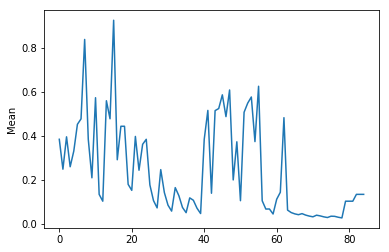

In [279]:
plt.plot(np.mean(features, axis=0))
plt.ylabel('Mean')
plt.show()

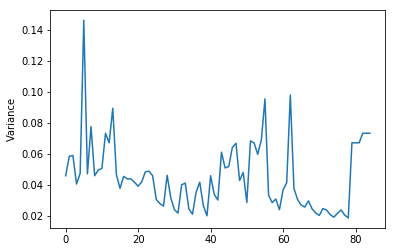

In [280]:
plt.plot(np.var(features, axis=0))
plt.ylabel('Variance')
plt.show()

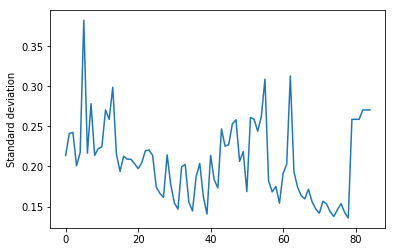

In [281]:
plt.plot(np.std(features, axis=0))
plt.ylabel('Standard deviation')
plt.show()

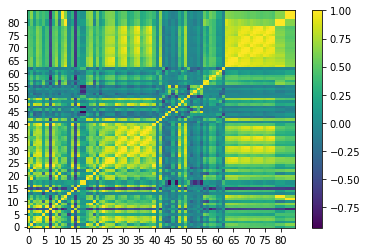

In [282]:
corrcoef = np.corrcoef(features, rowvar=False)

plt.pcolor(corrcoef)
plt.colorbar()
NUM_FEATURES = features.shape[1]
plt.yticks(np.arange(0.5, NUM_FEATURES + 0.5, 5), np.arange(0, NUM_FEATURES, 5))
plt.xticks(np.arange(0.5, NUM_FEATURES + 0.5, 5), np.arange(0, NUM_FEATURES, 5))
plt.show()

## Run PCA

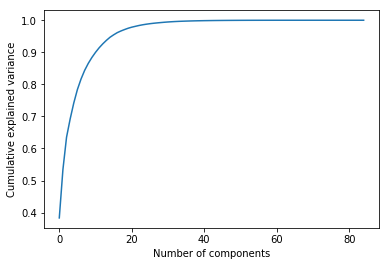

In [283]:
pca = PCA()
pca.fit(features)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

## Removing features with low variance

In [284]:
from sklearn.feature_selection import VarianceThreshold

THRESHOLD = 0.04
sel = VarianceThreshold(threshold=THRESHOLD)
sel.fit(features)

print('Number of features before removing:', features.shape[1])
features = sel.transform(features)
print('Number of features after removing:', features.shape[1])
print('Features indices removed:')
print(np.where(np.invert(sel.get_support()))[0])

Number of features before removing: 85
Number of features after removing: 47
Features indices removed:
[15 20 25 26 27 29 30 31 32 34 35 36 38 39 41 42 50 56 57 58 59 60 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78]


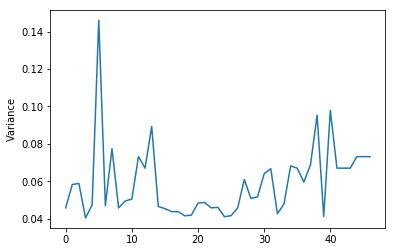

In [285]:
# Verify result.
plt.plot(np.var(features, axis=0))
plt.ylabel('Variance')
plt.show()

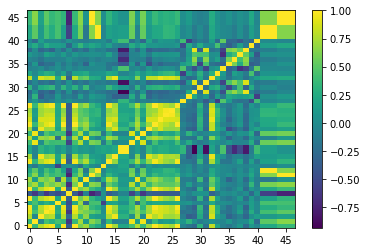

In [286]:
# Update Pearson correlation.
corrcoef = np.corrcoef(features, rowvar=False)

plt.pcolor(corrcoef)
plt.colorbar()
NUM_FEATURES = features.shape[1]
plt.yticks(np.arange(0.5, NUM_FEATURES + 0.5, 5), np.arange(0, NUM_FEATURES, 5))
plt.xticks(np.arange(0.5, NUM_FEATURES + 0.5, 5), np.arange(0, NUM_FEATURES, 5))
plt.show()

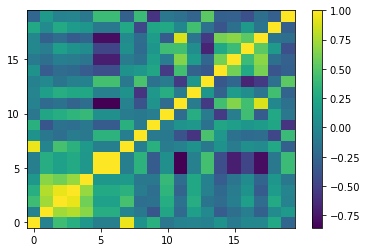

In [287]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
rfe = rfe.fit(features, labels)
features_new = rfe.transform(features)

corrcoef = np.corrcoef(features_new, rowvar=False)
plt.pcolor(corrcoef)
plt.colorbar()
NUM_FEATURES = features_new.shape[1]
plt.yticks(np.arange(0.5, NUM_FEATURES + 0.5, 5), np.arange(0, NUM_FEATURES, 5))
plt.xticks(np.arange(0.5, NUM_FEATURES + 0.5, 5), np.arange(0, NUM_FEATURES, 5))
plt.show()

In [288]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)
# model.feature_importances_
# np.flip(np.argsort(model.feature_importances_), axis=0)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)